In [1]:
# Read listed filenames, load JSON results, compute mean accuracy by kind and timestep, and plot
import os
import json
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

resiults_dir = "/home/wzarzecki/ds_10000x/results/probes"
file_list_path = "/data/wzarzecki/SAEtoRuleRFDiffusion/temp.txt"

# Read filenames from temp.txt
with open(file_list_path, "r") as f:
    filenames = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("//")]

# Pattern: kind_structure_tNUM.json or kind_structure_no_timestep.json
pat = re.compile(r'^(?P<kind>pair|non_pair|loose_concat)_(?P<structure>[^_]+)_(?:(?:t(?P<t>\d+))|no_timestep)\.json$')

# Collect accuracies by kind and timestep
data = defaultdict(lambda: defaultdict(list))
missing = []
for fn in filenames:
    m = pat.match(fn)
    if not m:
        missing.append(fn)
        continue
    kind = m.group('kind')
    t = m.group('t')
    timestep = int(t) if t is not None else 0
    path = os.path.join(resiults_dir, fn)
    try:
        with open(path, 'r') as j:
            d = json.load(j)
            acc = d.get('accuracy')
            if acc is None:
                # try other possible keys
                acc = d.get('balanced_accuracy')
            if acc is None:
                missing.append(fn)
                continue
            data[kind][timestep].append(float(acc))
    except FileNotFoundError:
        missing.append(fn)
    except Exception as e:
        missing.append(fn)

# Build a DataFrame of mean accuracies (rows: timestep, cols: kinds)
kinds = sorted(data.keys())
all_timesteps = sorted({ts for k in data.values() for ts in k.keys()})
if not all_timesteps:
    raise RuntimeError("No timesteps found in parsed files. Check file names and paths.")

df = pd.DataFrame(index=all_timesteps, columns=kinds, dtype=float)
for k in kinds:
    for ts in all_timesteps:
        vals = data[k].get(ts, [])
        df.at[ts, k] = np.mean(vals) if vals else np.nan

# Sort index
df = df.sort_index()

# Print summary
print("Parsed kinds:", kinds)
print("Missing or unparsed files (shown if any):", missing)
print('\nMean accuracy table (rows=timestep, cols=kind):')
print(df)

# Plot
plt.figure(figsize=(9,5))
for k in kinds:
    plt.plot(df.index, df[k], marker='o', label=k)

plt.xlabel('Timestep (0 = no_timestep)')
plt.title('Balanced accuracy by kind over timesteps for helix')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.xticks(df.index)
plt.tight_layout()

# Save and show
out_path = os.path.join(resiults_dir, 'accuracy_by_kind.png')
plt.savefig(out_path, dpi=150)
print(f"Saved plot to: {out_path}")
plt.show()


RuntimeError: No timesteps found in parsed files. Check file names and paths.


Mean n_train table (rows=timestep, cols=kind) — excluding timestep 0:
    concat  loose_concat  non_pair     pair
1     73.0        1185.0   11625.0  11625.0
2     87.0        1410.0   12390.0  12390.0
3     73.0        1125.0   11760.0  11760.0
4     76.0        1245.0   11580.0  11580.0
5     92.0        1440.0   12285.0  12285.0
6     83.0        1305.0   12105.0  12105.0
7     76.0        1170.0   12420.0  12420.0
8     75.0        1185.0   11880.0  11880.0
9     77.0        1215.0   11820.0  11820.0
10    76.0        1245.0   12060.0  12060.0
11    64.0         975.0   11460.0  11460.0
12    75.0        1140.0   11745.0  11745.0
13    79.0        1275.0   12585.0  12585.0
14    73.0        1110.0   11790.0  11790.0
15    84.0        1320.0   12390.0  12390.0
16    73.0        1110.0   12720.0  12720.0
17    76.0        1185.0   12555.0  12555.0
18    68.0        1050.0   12180.0  12180.0
19    66.0        1005.0   11595.0  11595.0
20    69.0        1080.0   11370.0  11370.0
21   

Saved train-size plot to: /home/wzarzecki/ds_10000x/results/probes/train_size_by_kind.png


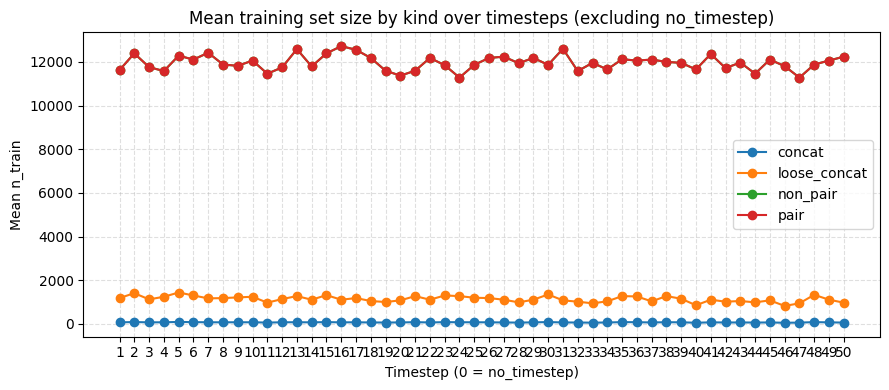

In [ ]:
# Compute mean training set size (n_train) per kind and timestep, and plot
from collections import defaultdict

# Collect n_train values
train_data = defaultdict(lambda: defaultdict(list))

pat = re.compile(r'^(?P<kind>pair|non_pair|concat|loose_concat)_(?P<structure>[^_]+)_(?:(?:t(?P<t>\d+))|no_timestep)\.json$')

# Ensure filenames/pattern exist
try:
    _filenames = filenames
except NameError:
    with open(file_list_path, 'r') as f:
        _filenames = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith('//')]

for fn in _filenames:
    m = pat.match(fn)
    if not m:
        continue
    kind = m.group('kind')
    t = m.group('t')
    ts = int(t) if t is not None else 0
    path = os.path.join(resiults_dir, fn)
    try:
        with open(path, 'r') as jf:
            d = json.load(jf)
            n = d.get('n_train')
            if n is None:
                # fallback keys
                n = d.get('n') or d.get('train_size') or d.get('n_train_samples')
            if n is not None:
                train_data[kind][ts].append(int(n))
    except Exception:
        # ignore missing/unreadable files here (they were reported earlier)
        continue

# Derive kinds and timesteps (exclude timestep 0)
ks = sorted(train_data.keys()) if train_data else (sorted(kinds) if 'kinds' in globals() else [])
ats = sorted({ts for k in train_data.values() for ts in k.keys() if ts != 0}) if train_data else (sorted([ts for ts in all_timesteps if ts != 0]) if 'all_timesteps' in globals() else [])

if not ks or not ats:
    print('No training size data found to plot (excluding no_timestep).')
else:
    df_train = pd.DataFrame(index=ats, columns=ks, dtype=float)
    for k in ks:
        for ts in ats:
            vals = train_data[k].get(ts, [])
            df_train.at[ts, k] = np.mean(vals) if vals else np.nan

    # Print table
    print('\nMean n_train table (rows=timestep, cols=kind) — excluding timestep 0:')
    print(df_train)

    # Plot
    plt.figure(figsize=(9,4))
    for k in ks:
        plt.plot(df_train.index, df_train[k], marker='o', label=k)
    plt.xlabel('Timestep (0 = no_timestep)')
    plt.ylabel('Mean n_train')
    plt.title('Mean training set size by kind over timesteps (excluding no_timestep)')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.xticks(df_train.index)
    plt.tight_layout()

    out_train_path = os.path.join(resiults_dir, 'train_size_by_kind.png')
    plt.savefig(out_train_path, dpi=150)
    print(f"Saved train-size plot to: {out_train_path}")
    plt.show()

In [2]:
non_pair_helix = "/home/wzarzecki/ds_10000x/coefs/non_pair_helix_no_timestep/coef.npy"
non_pair_beta = "/home/wzarzecki/ds_10000x/coefs/non_pair_beta_no_timestep/coef.npy"

non_pair_helix = np.load(non_pair_helix)
non_pair_beta = np.load(non_pair_beta)

In [3]:
non_pair_helix[0].shape

(4736,)

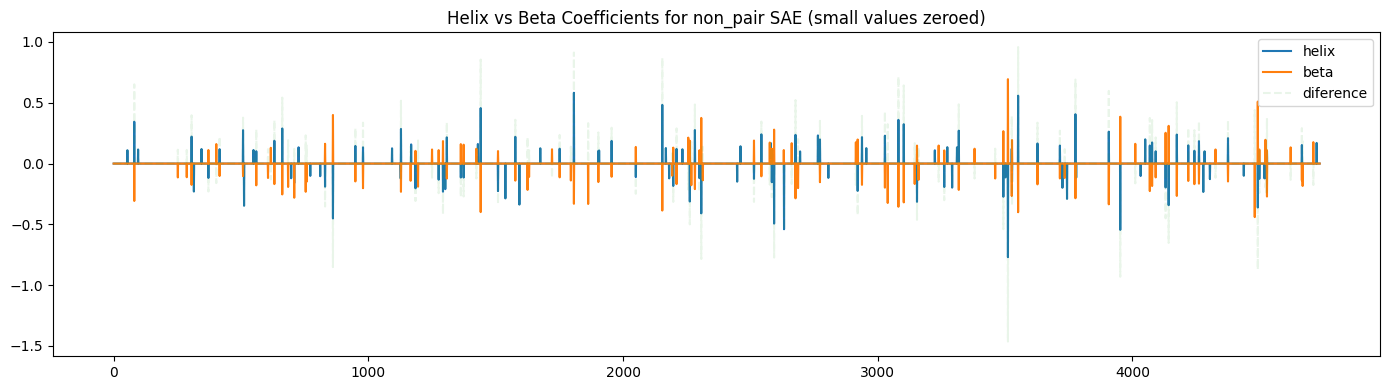

In [15]:
# Plot helix vs beta (zero small values, wider figure)
# copy arrays to avoid modifying originals
h = non_pair_helix[0].copy()
b = non_pair_beta[0].copy()


# set values in the range [-0.2, 0.2] to 0.0
h[np.abs(h) <= 0.1] = 0.0
b[np.abs(b) <= 0.1] = 0.0

plt.figure(figsize=(14,4))  # wider figure
plt.plot(h, label='helix')
plt.plot(b, label='beta')
plt.plot(h-b, label='diference', linestyle='--', alpha=0.1)
# plt.ylim(-0.2, 0.2)
plt.title('Helix vs Beta Coefficients for non_pair SAE (small values zeroed)')
plt.legend()
plt.tight_layout()
plt.show()

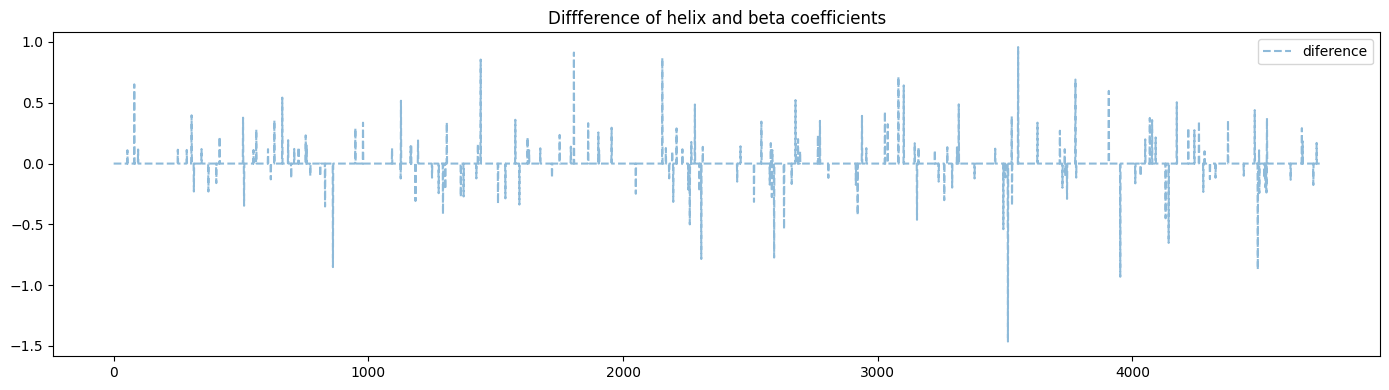

In [13]:
m = h - b
plt.figure(figsize=(14,4))
plt.plot(m, label='diference', linestyle='--', alpha=0.5)
plt.title('Diffference of helix and beta coefficients')
plt.legend()
plt.tight_layout()
plt.show()


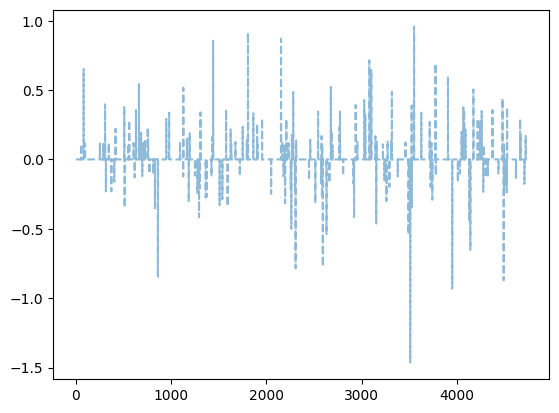

In [10]:
m_trim = b - h 
plt.plot(-m_trim, label='diference', linestyle='--', alpha=0.5)
plt.show()


Mean balanced_accuracy table (rows=timestep, cols=structure):
       helix      beta
0   0.841229  0.835079
1   0.974803  0.965804
2   0.976957  0.960018
3   0.977011  0.961969
4   0.979584  0.956716
5   0.981023  0.954087
6   0.976147  0.953372
7   0.983788  0.949492
8   0.984359  0.959531
9   0.974948  0.956907
10  0.977230  0.955950
11  0.980871  0.954574
12  0.972064  0.956236
13  0.976449  0.950222
14  0.975095  0.956586
15  0.974094  0.955883
16  0.974078  0.952091
17  0.971818  0.956150
18  0.968632  0.948537
19  0.969233  0.943672
20  0.966469  0.936090
21  0.966675  0.947365
22  0.963352  0.945502
23  0.962286  0.935002
24  0.951097  0.937633
25  0.949322  0.933671
26  0.936570  0.924184
27  0.931734  0.918044
28  0.928115  0.914718
29  0.920305  0.912809
30  0.900118  0.900133
31  0.885062  0.893515
32  0.856339  0.875153
33  0.846856  0.850507
34  0.804904  0.825152
35  0.777071  0.785556
36  0.756590  0.769279
37  0.722352  0.726018
38  0.693190  0.703180
39  0.662084  0.6

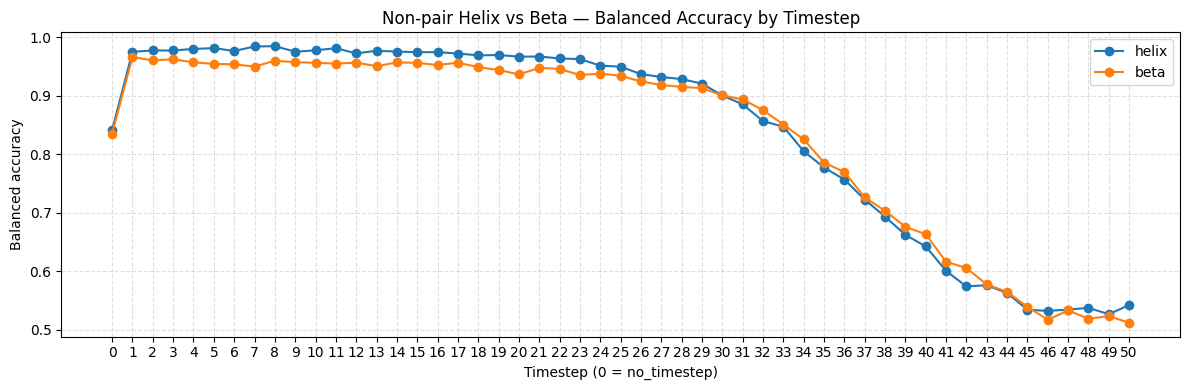

In [ ]:
# Aggregate balanced accuracy for non_pair helix and beta across timesteps and plot
import os
import json
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

resiults_dir = "/home/wzarzecki/ds_10000x/results/probes"
file_list_path = "/data/wzarzecki/SAEtoRuleRFDiffusion/temp.txt"

# Load filenames (reuse existing variable if present)
try:
    file_names = filenames
except NameError:
    with open(file_list_path, 'r') as f:
        file_names = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith('//')]

structures = ['helix', 'beta']
data = defaultdict(lambda: defaultdict(list))

for structure in structures:
    pat = re.compile(rf'^non_pair_{structure}_(?:(?:t(?P<t>\d+))|no_timestep)\.json$')
    for fn in file_names:
        m = pat.match(fn)
        if not m:
            continue
        t = m.group('t')
        ts = int(t) if t is not None else 0
        path = os.path.join(resiults_dir, fn)
        try:
            with open(path, 'r') as jf:
                d = json.load(jf)
                # accept multiple possible keys
                acc = d.get('balanced_accuracy') or d.get('balanced-accuracy') or d.get('accuracy')
                if acc is None:
                    continue
                data[structure][ts].append(float(acc))
        except Exception:
            # ignore missing/unreadable files
            continue

all_ts = sorted({ts for s in data.values() for ts in s.keys()})
if not all_ts:
    print('No timesteps found for non_pair helix/beta in the provided file list.')
else:
    df_acc = pd.DataFrame(index=all_ts, columns=structures, dtype=float)
    for s in structures:
        for ts in all_ts:
            vals = data[s].get(ts, [])
            df_acc.at[ts, s] = np.mean(vals) if vals else np.nan

    # Print table
    print('\nMean balanced_accuracy table (rows=timestep, cols=structure):')
    print(df_acc)

    # Plot
    plt.figure(figsize=(12,4))
    for s in structures:
        plt.plot(df_acc.index, df_acc[s], marker='o', label=s)
    plt.xlabel('Timestep (0 = no_timestep)')
    plt.ylabel('Balanced accuracy')
    plt.title('Non-pair Helix vs Beta — Balanced Accuracy by Timestep')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.xticks(df_acc.index)
    plt.tight_layout()

    out_path = os.path.join(resiults_dir, 'non_pair_helix_beta_balanced_accuracy.png')
    plt.savefig(out_path, dpi=150)
    print(f"Saved plot to: {out_path}")
    plt.show()